In [138]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os  
import glob
import pickle
import math
%matplotlib inline

In [139]:
################ Defining Undistort Function ################
f_file = open("cal_info.pkl", "rb")
cal_info = pickle.load(f_file)
f_file.close()
def undistort(img):
    mtx = cal_info["mtx"]
    dist = cal_info["dist"]
    un_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return un_img

In [140]:
################ Defining Binary Image ################
def binary_image(img, s_thresh=(140, 255), sx_thresh=(50, 255)):
    ########### Binary image for Color #################
    # Going to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    ########## Binary image for Gradiant ##############
    # Converting to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Getting x derivative
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # Getting absolute value
    abs_sobelx = np.absolute(sobelx)
    # Scaling and Converting to 8-bit
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Applying thresholds
    sx_binary = np.zeros_like(gray)
    sx_binary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Defining the binary and binay_color
    binary = np.zeros_like(s_binary)
    binary[(s_binary == 1) | (sx_binary == 1)] = 1
    color_binary = np.dstack((s_binary, sx_binary, np.zeros_like(sx_binary)))*255
    
    return binary, color_binary

In [141]:
################ Defining Perspective Transform Function ################
# Loading the already indentified perspective info
f_file = open("perspective_info", "rb")
perspective_info = pickle.load(f_file)
f_file.close()
# Grabbing the M and Minv matrix
M = perspective_info["M"]
Minv = perspective_info["Minv"]

def warp(img, ptype=0):
    img_size = (img.shape[1], img.shape[0])
    if ptype == 0:
        un_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        un_img = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return un_img

In [142]:
################ Defining Histogram Function ################
def hist(img):
    # input for this function is the warped binary image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis=0)
    # The output is a 1D array of img.shape[1] length
    return histogram

In [160]:
################ Defining the Function for Sliding Window ################
def slide_search(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 10
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Coloring the lane pixels
    out_img[lefty, leftx] = [255,0,0]
    out_img[righty, rightx] = [0,0,255]
    
    # Warping back the output image
    out_img = warp(out_img, ptype=1)
    
    return leftx, lefty, rightx, righty, out_img

In [161]:
################ Defining the Function for Searching Around Polynomials ################
def poly_search(binary_warped, left_fit, right_fit):
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ## Visualization of the search area and margins
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Coloring the lane pixels
    out_img[lefty, leftx] = [255,0,0]
    out_img[righty, rightx] = [0,0,255]
    
    window_img = np.zeros_like(out_img)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    # warping back the image
    result = warp(result, ptype=1)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return leftx, lefty, rightx, righty, result

In [248]:
def fit_polynomial(line):
    # Find line pixels using slide_search
    allx = line.allx
    ally = line.ally

    if allx.size == 0 or ally.size == 0:
        fit = np.array([])
        fitx = np.array([])
    else:
        # Fit a second order polynomial to each using `np.polyfit`
        fit = np.polyfit(ally, allx, 2)

        # Generate x and y values for plotting
        ploty = line.ploty
        try:
            fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        #out_img[lefty, leftx] = [255, 0, 0]
        #out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')

    return fit, fitx

In [249]:
def visualize(warped, left, right):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    # For the shaded green safe area
    color_warp_1 = np.dstack((warp_zero, warp_zero, warp_zero))
    # For the line colors and the text
    color_warp_2 = np.dstack((warp_zero, warp_zero, warp_zero))

    if left.last_xfitted != [] and right.last_xfitted != []:
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left.last_xfitted, left.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right.last_xfitted, right.ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp_1, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp_1 = warp(color_warp_1, ptype=1)  
    
    # Coloring the line pixles
    #if left.vis:
    #color_warp_2[left.ally, left.allx] = left.color
    #if right.vis:
    #color_warp_2[right.ally, right.allx] = right.color
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp_2 = warp(color_warp_2, ptype=1) 
    
    if left.radius != None and right.radius != None:
        # Writing the radius on the image
        font = cv2.FONT_HERSHEY_SIMPLEX
        radius = (left.radius + right.radius)/2000
        # Avoiding ridiculously large radius values
        if radius > 5:
            str1 = "_"
        else:
            str1 = str(round(radius, 2))
        cv2.putText(newwarp_2,
                    "Radius of Curvature = " + str1 + " km",
                    (10,30),
                    font,
                    1,
                    (255, 255, 255),
                    2,
                    cv2.LINE_AA)
    if left.last_xfitted != [] and right.last_xfitted != []:
        # Finding the vehicle distance w.r.t. center line
        xm_per_pix = 3.7/480 # meters per pixel in x dimension
        dist = (warped.shape[1]/2 - (right.last_xfitted[-1] + left.last_xfitted[-1])/2) * xm_per_pix
        cv2.putText(newwarp_2,
                    "Distance from the lane center = " + str(round(dist, 2)) + " m",
                    (10,60),
                    font,
                    1,
                    (255, 255, 255),
                    2,
                    cv2.LINE_AA)

    return newwarp_1, newwarp_2

In [250]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # array of y values from 0 to img.shape[0]
        self.ploty = []
        # Number of last fits to hold
        self.n = 5
        # x values of the last fit of the line
        self.last_xfitted = [] 
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients for the last n recent fits
        self.recent_fit = []  
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # Line color for visualization
        self.color = [255,0,0]
        # Line radius of curvature
        self.radius = None
    
    def x_append(self):
        if len(self.recent_xfitted) == self.n:
            self.recent_xfitted.pop(0)
            self.recent_xfitted.append(self.last_xfitted)
        else:
            self.recent_xfitted.append(self.last_xfitted)
    
    def fit_append(self):
        if len(self.recent_fit) == self.n:
            self.recent_fit.pop(0)
            self.recent_fit.append(self.current_fit)
        else:
            self.recent_fit.append(self.current_fit)
    
    def update(self):
        self.bestx = np.mean(np.array(self.recent_xfitted), axis=0)
        self.best_fit = np.mean(np.array(self.recent_fit), axis=0)
        if len(self.recent_fit) > 1:
            self.diffs = np.array(self.recent_fit[-1] - self.recent_fit[-2])
        # Calculating the radius of curvature
        y_eval = np.max(self.ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 70/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/480 # meters per pixel in x dimension
        if self.best_fit.any() != None:
            self.radius = (1 + (2*self.best_fit[0] * y_eval * (xm_per_pix/ym_per_pix) + self.best_fit[1] * (xm_per_pix/ym_per_pix))**2)**1.5/np.absolute(2*self.best_fit[0] * xm_per_pix / ym_per_pix**2) 

In [251]:
def fit_check(left_fit, left_fitx, right_fit, right_fitx):
    flag = True
    # Checking if fit values are valid
    if left_fit.size == 0 or left_fitx.size == 0 or right_fit.size == 0 or right_fitx.size == 0:
        flag = False
    else:
        # Chekcing for the base distance to be reasonable
        if np.max(right_fitx - left_fitx) > 600 or np.min(right_fitx - left_fitx) < 350:
            flag = False

        # Checking for the curvature
        if (10**4 * np.absolute(right_fit[0] - left_fit[0]) + (right_fit[1] - left_fit[1])) > 10:
            flag = False
        
    return flag

In [252]:
Left = Line()
Right = Line()
Right.color = [0,0,255]
################ Defining the Pipeline ################
def pipeline(img_in):
    img = np.copy(img_in)
    un_img = undistort(img)
    binary_img, _ = binary_image(un_img, s_thresh=(200, 255), sx_thresh=(50, 255))
    binary_warped = warp(binary_img)
    
    # Setting the ploty value of the lines
    Left.ploty = np.linspace(0, img.shape[0]-1, img.shape[0])  
    Right.ploty = np.linspace(0, img.shape[0]-1, img.shape[0])  
    
    if Left.detected and Right.detected:
        leftx, lefty, rightx, righty, out_img = poly_search(binary_warped, Left.current_fit, Right.current_fit)
        Left.allx = leftx
        Left.ally = lefty
        Right.allx = rightx
        Right.ally = righty
        left_fit, left_fitx = fit_polynomial(Left)
        right_fit, right_fitx = fit_polynomial(Right)
        
        # Keeping track of the number of frames the lanes couldn't be identified by counter
        counter = 0
        
        if fit_check(left_fit, left_fitx, right_fit, right_fitx):
            # Appending the current fit values to the list of last n fit values
            Left.current_fit = left_fit
            Left.fit_append()
            Right.current_fit = right_fit
            Right.fit_append()
            # Appending the current x values to the list of last n x values
            Left.last_xfitted = left_fitx
            Left.x_append()
            Right.last_xfitted = right_fitx
            Right.x_append()
            # Updating the objects
            Left.update()
            Right.update()
            # Reseting counter
            counter = 0

        else:
            counter += 1 
            # Going to slide search if lanes couldn't be fined for more than predefined number of frames
            if counter >= 20:
                counter = 0
                Left.detected = False
                Right.detected = False
    else:
        leftx, lefty, rightx, righty, out_img = slide_search(binary_warped)
        Left.allx = leftx
        Left.ally = lefty
        Right.allx = rightx
        Right.ally = righty
        left_fit, left_fitx = fit_polynomial(Left)
        right_fit, right_fitx = fit_polynomial(Right)
        if fit_check(left_fit, left_fitx, right_fit, right_fitx):
            # Alright we are back on track and lanes are identified
            Left.detected = True
            Right.detected = True
            
            # Appending the current fit values to the list of last n fit values
            Left.current_fit = left_fit
            Left.fit_append()
            Right.current_fit = right_fit
            Right.fit_append()
            # Appending the current x values to the list of last n x values
            Left.last_xfitted = left_fitx
            Left.x_append()
            Right.last_xfitted = right_fitx
            Right.x_append()
            # Updating the objects
            Left.update()
            Right.update()

    img_vis_1, img_vis_2 = visualize(binary_warped, Left, Right)
    final_img = cv2.addWeighted(img, 1, img_vis_1, 0.3, 0)
    final_img = cv2.addWeighted(final_img, 1, img_vis_2, 1, 0)    
    
    #final_img = cv2.addWeighted(out_img, 1, img, 0.5, 0)
    
    # Writing the radius on the image
    #font = cv2.FONT_HERSHEY_SIMPLEX
    #cv2.putText(final_img,
    #            "fit check = " + str(fit_check(left_fit, left_fitx, right_fit, right_fitx)),
    #            (10,90),
    #            font,
    #            1,
    #            (255, 255, 255),
    #            2,
    #            cv2.LINE_AA)
    
    return final_img

In [253]:
test_images = glob.glob("..\\test_images\\*.jpg")
img = mpimg.imread(test_images[2])   

Text(0.5, 1.0, 'Output')

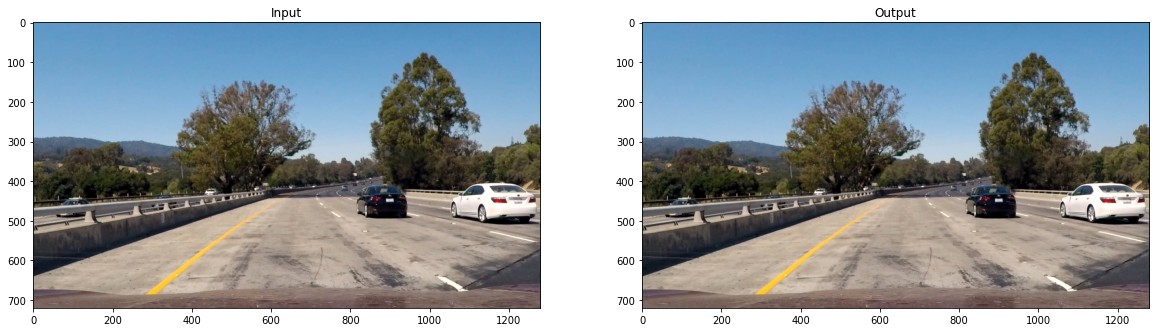

In [223]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title("Input")
ax2.imshow(pipeline(img)) 
ax2.set_title("Output")

In [137]:
Left.recent_fi

[array([-3.38400529e-05,  4.92583622e-02,  3.87024353e+02]),
 array([-3.38400529e-05,  4.92583622e-02,  3.87024353e+02])]

In [244]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [245]:
test_videos = glob.glob("..\\*.mp4")
test_videos

['..\\challenge_video.mp4',
 '..\\harder_challenge_video.mp4',
 '..\\project_video.mp4']

In [259]:
#clip1 = VideoFileClip(test_videos[2]).subclip(40,46)
clip1 = VideoFileClip(test_videos[2])

In [257]:
out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
clip_output = "..\\test_videos_output\\clip_output.mp4"
%time out_clip.write_videofile(clip_output, audio=False)

                                                                                                                       

                                                                                                                 
t:  28%|██████████████████▌                                                | 134/485 [17:16<00:38,  9.07it/s, now=None]

t:  28%|██████████████████▌                                                | 134/485 [07:28<00:39,  8.78it/s, now=None]
                                                                                                                       

                                                                                                                 
t:  28%|██████████████████▌                                                | 134/485 [17:16<00:38,  9.07it/s, now=None]

t:  28%|██████████████████▌                                                | 134/485 [11:47<00:40,  8.68it/s, now=None]


t:   0%|                                      

Moviepy - Building video ..\test_videos_output\clip_output.mp4.
Moviepy - Writing video ..\test_videos_output\clip_output.mp4






t:   0%|▏                                                                   | 3/1199 [00:00<01:41, 11.81it/s, now=None]


t:   0%|▏                                                                   | 4/1199 [00:00<01:50, 10.81it/s, now=None]


t:   0%|▎                                                                   | 5/1199 [00:00<01:56, 10.21it/s, now=None]


t:   1%|▎                                                                   | 6/1199 [00:00<02:03,  9.68it/s, now=None]


t:   1%|▍                                                                   | 7/1199 [00:00<02:05,  9.53it/s, now=None]


t:   1%|▍                                                                   | 8/1199 [00:00<02:07,  9.38it/s, now=None]


t:   1%|▌                                                                   | 9/1199 [00:00<02:09,  9.22it/s, now=None]


t:   1%|▌                                                                  | 10/1199 [00:01<02:10,  9.14it/s, now=None]


t:   1%|▌            

t:   5%|███▋                                                               | 65/1199 [00:07<02:16,  8.29it/s, now=None]


t:   6%|███▋                                                               | 66/1199 [00:07<02:17,  8.25it/s, now=None]


t:   6%|███▋                                                               | 67/1199 [00:07<02:16,  8.32it/s, now=None]


t:   6%|███▊                                                               | 68/1199 [00:07<02:15,  8.37it/s, now=None]


t:   6%|███▊                                                               | 69/1199 [00:07<02:14,  8.41it/s, now=None]


t:   6%|███▉                                                               | 70/1199 [00:07<02:14,  8.39it/s, now=None]


t:   6%|███▉                                                               | 71/1199 [00:08<02:13,  8.42it/s, now=None]


t:   6%|████                                                               | 72/1199 [00:08<02:15,  8.34it/s, now=None]


t:   6%|████            

t:  11%|██████▉                                                           | 127/1199 [00:14<02:02,  8.76it/s, now=None]


t:  11%|███████                                                           | 128/1199 [00:14<02:02,  8.75it/s, now=None]


t:  11%|███████                                                           | 129/1199 [00:14<02:01,  8.78it/s, now=None]


t:  11%|███████▏                                                          | 130/1199 [00:15<02:01,  8.79it/s, now=None]


t:  11%|███████▏                                                          | 131/1199 [00:15<02:01,  8.79it/s, now=None]


t:  11%|███████▎                                                          | 132/1199 [00:15<02:00,  8.89it/s, now=None]


t:  11%|███████▎                                                          | 133/1199 [00:15<02:03,  8.65it/s, now=None]


t:  11%|███████▍                                                          | 134/1199 [00:15<02:03,  8.60it/s, now=None]


t:  11%|███████▍        

t:  16%|██████████▍                                                       | 189/1199 [00:21<01:53,  8.91it/s, now=None]


t:  16%|██████████▍                                                       | 190/1199 [00:21<01:53,  8.90it/s, now=None]


t:  16%|██████████▌                                                       | 191/1199 [00:22<01:53,  8.87it/s, now=None]


t:  16%|██████████▌                                                       | 192/1199 [00:22<01:55,  8.73it/s, now=None]


t:  16%|██████████▌                                                       | 193/1199 [00:22<01:56,  8.64it/s, now=None]


t:  16%|██████████▋                                                       | 194/1199 [00:22<01:58,  8.51it/s, now=None]


t:  16%|██████████▋                                                       | 195/1199 [00:22<01:58,  8.48it/s, now=None]


t:  16%|██████████▊                                                       | 196/1199 [00:22<01:58,  8.47it/s, now=None]


t:  16%|██████████▊     

t:  21%|█████████████▊                                                    | 251/1199 [00:29<01:56,  8.14it/s, now=None]


t:  21%|█████████████▊                                                    | 252/1199 [00:29<01:55,  8.21it/s, now=None]


t:  21%|█████████████▉                                                    | 253/1199 [00:29<01:55,  8.21it/s, now=None]


t:  21%|█████████████▉                                                    | 254/1199 [00:29<01:54,  8.25it/s, now=None]


t:  21%|██████████████                                                    | 255/1199 [00:29<01:51,  8.45it/s, now=None]


t:  21%|██████████████                                                    | 256/1199 [00:29<01:53,  8.34it/s, now=None]


t:  21%|██████████████▏                                                   | 257/1199 [00:30<01:51,  8.45it/s, now=None]


t:  22%|██████████████▏                                                   | 258/1199 [00:30<01:50,  8.48it/s, now=None]


t:  22%|██████████████▎ 

t:  26%|█████████████████▏                                                | 313/1199 [00:36<01:41,  8.70it/s, now=None]


t:  26%|█████████████████▎                                                | 314/1199 [00:36<01:43,  8.57it/s, now=None]


t:  26%|█████████████████▎                                                | 315/1199 [00:36<01:42,  8.66it/s, now=None]


t:  26%|█████████████████▍                                                | 316/1199 [00:37<01:41,  8.68it/s, now=None]


t:  26%|█████████████████▍                                                | 317/1199 [00:37<01:41,  8.69it/s, now=None]


t:  27%|█████████████████▌                                                | 318/1199 [00:37<01:41,  8.65it/s, now=None]


t:  27%|█████████████████▌                                                | 319/1199 [00:37<01:41,  8.65it/s, now=None]


t:  27%|█████████████████▌                                                | 320/1199 [00:37<01:42,  8.60it/s, now=None]


t:  27%|████████████████

t:  31%|████████████████████▋                                             | 375/1199 [00:44<02:26,  5.63it/s, now=None]


t:  31%|████████████████████▋                                             | 376/1199 [00:44<02:23,  5.73it/s, now=None]


t:  31%|████████████████████▊                                             | 377/1199 [00:45<02:20,  5.87it/s, now=None]


t:  32%|████████████████████▊                                             | 378/1199 [00:45<02:19,  5.89it/s, now=None]


t:  32%|████████████████████▊                                             | 379/1199 [00:45<02:17,  5.96it/s, now=None]


t:  32%|████████████████████▉                                             | 380/1199 [00:45<02:15,  6.05it/s, now=None]


t:  32%|████████████████████▉                                             | 381/1199 [00:45<02:15,  6.02it/s, now=None]


t:  32%|█████████████████████                                             | 382/1199 [00:45<02:15,  6.03it/s, now=None]


t:  32%|████████████████

t:  36%|████████████████████████                                          | 437/1199 [00:54<01:42,  7.47it/s, now=None]


t:  37%|████████████████████████                                          | 438/1199 [00:54<01:39,  7.63it/s, now=None]


t:  37%|████████████████████████▏                                         | 439/1199 [00:54<01:41,  7.48it/s, now=None]


t:  37%|████████████████████████▏                                         | 440/1199 [00:54<01:41,  7.50it/s, now=None]


t:  37%|████████████████████████▎                                         | 441/1199 [00:54<01:39,  7.63it/s, now=None]


t:  37%|████████████████████████▎                                         | 442/1199 [00:55<01:38,  7.67it/s, now=None]


t:  37%|████████████████████████▍                                         | 443/1199 [00:55<01:37,  7.74it/s, now=None]


t:  37%|████████████████████████▍                                         | 444/1199 [00:55<01:34,  8.01it/s, now=None]


t:  37%|████████████████

t:  42%|███████████████████████████▍                                      | 499/1199 [01:02<01:25,  8.16it/s, now=None]


t:  42%|███████████████████████████▌                                      | 500/1199 [01:02<01:25,  8.14it/s, now=None]


t:  42%|███████████████████████████▌                                      | 501/1199 [01:02<01:24,  8.30it/s, now=None]


t:  42%|███████████████████████████▋                                      | 502/1199 [01:02<01:22,  8.49it/s, now=None]


t:  42%|███████████████████████████▋                                      | 503/1199 [01:02<01:22,  8.45it/s, now=None]


t:  42%|███████████████████████████▋                                      | 504/1199 [01:02<01:25,  8.09it/s, now=None]


t:  42%|███████████████████████████▊                                      | 505/1199 [01:02<01:25,  8.09it/s, now=None]


t:  42%|███████████████████████████▊                                      | 506/1199 [01:02<01:25,  8.09it/s, now=None]


t:  42%|████████████████

t:  47%|██████████████████████████████▉                                   | 561/1199 [01:09<01:14,  8.55it/s, now=None]


t:  47%|██████████████████████████████▉                                   | 562/1199 [01:09<01:13,  8.62it/s, now=None]


t:  47%|██████████████████████████████▉                                   | 563/1199 [01:09<01:14,  8.52it/s, now=None]


t:  47%|███████████████████████████████                                   | 564/1199 [01:09<01:14,  8.56it/s, now=None]


t:  47%|███████████████████████████████                                   | 565/1199 [01:09<01:14,  8.54it/s, now=None]


t:  47%|███████████████████████████████▏                                  | 566/1199 [01:09<01:13,  8.57it/s, now=None]


t:  47%|███████████████████████████████▏                                  | 567/1199 [01:10<01:13,  8.57it/s, now=None]


t:  47%|███████████████████████████████▎                                  | 568/1199 [01:10<01:13,  8.57it/s, now=None]


t:  47%|████████████████

t:  52%|██████████████████████████████████▎                               | 623/1199 [01:16<01:11,  8.08it/s, now=None]


t:  52%|██████████████████████████████████▎                               | 624/1199 [01:16<01:12,  7.96it/s, now=None]


t:  52%|██████████████████████████████████▍                               | 625/1199 [01:16<01:12,  7.96it/s, now=None]


t:  52%|██████████████████████████████████▍                               | 626/1199 [01:17<01:13,  7.85it/s, now=None]


t:  52%|██████████████████████████████████▌                               | 627/1199 [01:17<01:14,  7.68it/s, now=None]


t:  52%|██████████████████████████████████▌                               | 628/1199 [01:17<01:17,  7.39it/s, now=None]


t:  52%|██████████████████████████████████▌                               | 629/1199 [01:17<01:19,  7.19it/s, now=None]


t:  53%|██████████████████████████████████▋                               | 630/1199 [01:17<01:20,  7.03it/s, now=None]


t:  53%|████████████████

t:  57%|█████████████████████████████████████▋                            | 685/1199 [01:25<01:05,  7.88it/s, now=None]


t:  57%|█████████████████████████████████████▊                            | 686/1199 [01:25<01:03,  8.05it/s, now=None]


t:  57%|█████████████████████████████████████▊                            | 687/1199 [01:25<01:03,  8.08it/s, now=None]


t:  57%|█████████████████████████████████████▊                            | 688/1199 [01:26<01:02,  8.20it/s, now=None]


t:  57%|█████████████████████████████████████▉                            | 689/1199 [01:26<01:02,  8.21it/s, now=None]


t:  58%|█████████████████████████████████████▉                            | 690/1199 [01:26<01:02,  8.15it/s, now=None]


t:  58%|██████████████████████████████████████                            | 691/1199 [01:26<01:02,  8.13it/s, now=None]


t:  58%|██████████████████████████████████████                            | 692/1199 [01:26<01:02,  8.10it/s, now=None]


t:  58%|████████████████

t:  62%|█████████████████████████████████████████                         | 747/1199 [01:33<00:56,  8.02it/s, now=None]


t:  62%|█████████████████████████████████████████▏                        | 748/1199 [01:33<00:57,  7.91it/s, now=None]


t:  62%|█████████████████████████████████████████▏                        | 749/1199 [01:33<00:56,  8.04it/s, now=None]


t:  63%|█████████████████████████████████████████▎                        | 750/1199 [01:33<00:54,  8.17it/s, now=None]


t:  63%|█████████████████████████████████████████▎                        | 751/1199 [01:33<00:54,  8.18it/s, now=None]


t:  63%|█████████████████████████████████████████▍                        | 752/1199 [01:33<00:55,  8.00it/s, now=None]


t:  63%|█████████████████████████████████████████▍                        | 753/1199 [01:33<00:56,  7.85it/s, now=None]


t:  63%|█████████████████████████████████████████▌                        | 754/1199 [01:34<00:56,  7.87it/s, now=None]


t:  63%|████████████████

t:  67%|████████████████████████████████████████████▌                     | 809/1199 [01:40<00:47,  8.17it/s, now=None]


t:  68%|████████████████████████████████████████████▌                     | 810/1199 [01:41<00:47,  8.14it/s, now=None]


t:  68%|████████████████████████████████████████████▋                     | 811/1199 [01:41<00:47,  8.13it/s, now=None]


t:  68%|████████████████████████████████████████████▋                     | 812/1199 [01:41<00:48,  8.02it/s, now=None]


t:  68%|████████████████████████████████████████████▊                     | 813/1199 [01:41<00:47,  8.10it/s, now=None]


t:  68%|████████████████████████████████████████████▊                     | 814/1199 [01:41<00:46,  8.25it/s, now=None]


t:  68%|████████████████████████████████████████████▊                     | 815/1199 [01:41<00:46,  8.18it/s, now=None]


t:  68%|████████████████████████████████████████████▉                     | 816/1199 [01:41<00:46,  8.25it/s, now=None]


t:  68%|████████████████

t:  73%|███████████████████████████████████████████████▉                  | 871/1199 [01:49<00:53,  6.10it/s, now=None]


t:  73%|████████████████████████████████████████████████                  | 872/1199 [01:50<00:52,  6.23it/s, now=None]


t:  73%|████████████████████████████████████████████████                  | 873/1199 [01:50<00:51,  6.33it/s, now=None]


t:  73%|████████████████████████████████████████████████                  | 874/1199 [01:50<00:50,  6.42it/s, now=None]


t:  73%|████████████████████████████████████████████████▏                 | 875/1199 [01:50<00:50,  6.45it/s, now=None]


t:  73%|████████████████████████████████████████████████▏                 | 876/1199 [01:50<00:49,  6.51it/s, now=None]


t:  73%|████████████████████████████████████████████████▎                 | 877/1199 [01:50<00:48,  6.58it/s, now=None]


t:  73%|████████████████████████████████████████████████▎                 | 878/1199 [01:51<00:49,  6.50it/s, now=None]


t:  73%|████████████████

t:  78%|███████████████████████████████████████████████████▎              | 933/1199 [01:57<00:30,  8.73it/s, now=None]


t:  78%|███████████████████████████████████████████████████▍              | 934/1199 [01:57<00:30,  8.73it/s, now=None]


t:  78%|███████████████████████████████████████████████████▍              | 935/1199 [01:57<00:30,  8.68it/s, now=None]


t:  78%|███████████████████████████████████████████████████▌              | 936/1199 [01:57<00:30,  8.72it/s, now=None]


t:  78%|███████████████████████████████████████████████████▌              | 937/1199 [01:58<00:30,  8.72it/s, now=None]


t:  78%|███████████████████████████████████████████████████▋              | 938/1199 [01:58<00:29,  8.83it/s, now=None]


t:  78%|███████████████████████████████████████████████████▋              | 939/1199 [01:58<00:28,  8.99it/s, now=None]


t:  78%|███████████████████████████████████████████████████▋              | 940/1199 [01:58<00:28,  9.03it/s, now=None]


t:  78%|████████████████

t:  83%|██████████████████████████████████████████████████████▊           | 995/1199 [02:04<00:25,  8.16it/s, now=None]


t:  83%|██████████████████████████████████████████████████████▊           | 996/1199 [02:04<00:25,  8.10it/s, now=None]


t:  83%|██████████████████████████████████████████████████████▉           | 997/1199 [02:04<00:24,  8.27it/s, now=None]


t:  83%|██████████████████████████████████████████████████████▉           | 998/1199 [02:05<00:23,  8.40it/s, now=None]


t:  83%|██████████████████████████████████████████████████████▉           | 999/1199 [02:05<00:23,  8.54it/s, now=None]


t:  83%|██████████████████████████████████████████████████████▏          | 1000/1199 [02:05<00:23,  8.59it/s, now=None]


t:  83%|██████████████████████████████████████████████████████▎          | 1001/1199 [02:05<00:22,  8.63it/s, now=None]


t:  84%|██████████████████████████████████████████████████████▎          | 1002/1199 [02:05<00:22,  8.57it/s, now=None]


t:  84%|████████████████

t:  88%|█████████████████████████████████████████████████████████▎       | 1058/1199 [02:12<00:17,  8.26it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████▍       | 1059/1199 [02:12<00:16,  8.29it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████▍       | 1060/1199 [02:12<00:16,  8.42it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████▌       | 1061/1199 [02:12<00:16,  8.46it/s, now=None]


t:  89%|█████████████████████████████████████████████████████████▌       | 1062/1199 [02:12<00:16,  8.41it/s, now=None]


t:  89%|█████████████████████████████████████████████████████████▋       | 1063/1199 [02:12<00:16,  8.29it/s, now=None]


t:  89%|█████████████████████████████████████████████████████████▋       | 1064/1199 [02:13<00:15,  8.48it/s, now=None]


t:  89%|█████████████████████████████████████████████████████████▋       | 1065/1199 [02:13<00:16,  8.31it/s, now=None]


t:  89%|████████████████

t:  93%|████████████████████████████████████████████████████████████▋    | 1120/1199 [02:20<00:09,  8.25it/s, now=None]


t:  93%|████████████████████████████████████████████████████████████▊    | 1121/1199 [02:20<00:09,  8.20it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████▊    | 1122/1199 [02:20<00:09,  8.27it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████▉    | 1123/1199 [02:20<00:09,  8.27it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████▉    | 1124/1199 [02:20<00:09,  8.30it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████▉    | 1125/1199 [02:20<00:08,  8.29it/s, now=None]


t:  94%|█████████████████████████████████████████████████████████████    | 1126/1199 [02:21<00:08,  8.21it/s, now=None]


t:  94%|█████████████████████████████████████████████████████████████    | 1127/1199 [02:21<00:08,  8.23it/s, now=None]


t:  94%|████████████████

t:  99%|████████████████████████████████████████████████████████████████ | 1182/1199 [02:28<00:02,  8.36it/s, now=None]


t:  99%|████████████████████████████████████████████████████████████████▏| 1183/1199 [02:28<00:01,  8.25it/s, now=None]


t:  99%|████████████████████████████████████████████████████████████████▏| 1184/1199 [02:28<00:01,  8.39it/s, now=None]


t:  99%|████████████████████████████████████████████████████████████████▏| 1185/1199 [02:28<00:01,  8.46it/s, now=None]


t:  99%|████████████████████████████████████████████████████████████████▎| 1186/1199 [02:28<00:01,  8.56it/s, now=None]


t:  99%|████████████████████████████████████████████████████████████████▎| 1187/1199 [02:28<00:01,  8.39it/s, now=None]


t:  99%|████████████████████████████████████████████████████████████████▍| 1188/1199 [02:28<00:01,  8.38it/s, now=None]


t:  99%|████████████████████████████████████████████████████████████████▍| 1189/1199 [02:28<00:01,  8.39it/s, now=None]


t:  99%|████████████████

Moviepy - Done !
Moviepy - video ready ..\test_videos_output\clip_output.mp4
Wall time: 2min 31s


In [258]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))